In [1]:
import jax.numpy as np
import numpy as onp
from NODE_fns import NODE, NODE_nobias
from jax import grad, random, jit, vmap
from functools import partial
from jax.experimental import optimizers
import pickle
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
key = random.PRNGKey(0)

/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
eta_D = 1360
eta_V = 175000

In [3]:
def init_params_positivebias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    b = np.zeros(layers[i + 1])
    return Ws, b
def init_params_nobias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws


taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()

taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std1 = onp.std(tau1)
inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = [inp_std1, inp_std2, inp_std3, inp_std4, inp_std5]

out_std1 = 1.0
out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = [out_std1, out_std2, out_std3, out_std4, out_std5]

# layers = [1, 5, 5, 1]
layers = [1,2,3,1]

### 1. Train only 2 Neural ODEs, individually.

In [4]:
def dPhi_gov1(tau_i, etad = 1360, etav = 175000): #The part of govindjee with I_1^2 only
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/9/etav)*trtau
    dphidtau2 = 2*(1/9/etav)*trtau
    dphidtau3 = 2*(1/9/etav)*trtau
    return [dphidtau1, dphidtau2, dphidtau3]

def dPhi_gov2(tau_i, etad = 1360, etav = 175000): #The part of govindjee with I_1^2-3I_2
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2/3/etad*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2/3/etad*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2/3/etad*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]


dphidtaui1 = onp.zeros_like(taui)
for i in range(taui.shape[0]):
    dphidtaui1[i] = dPhi_gov1(taui[i], etad=eta_D, etav=eta_V)
dphidtaui2 = onp.zeros_like(taui)
for i in range(taui.shape[0]):
    dphidtaui2[i] = dPhi_gov2(taui[i], etad=eta_D, etav=eta_V)
    
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)

def dPhi1(params, tau1, tau2, tau3):
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I4 = I4/inp_std4
    N4 = NODE(I4, params) #I1^2
    N4 = N4*out_std4

    Phi1 = 2*N4*(tau1 + tau2 + tau3)
    Phi2 = 2*N4*(tau1 + tau2 + tau3)
    Phi3 = 2*N4*(tau1 + tau2 + tau3)
    return Phi1, Phi2, Phi3
dPhi1_vmap = vmap(dPhi1, in_axes=(None, 0, 0, 0), out_axes = (0, 0, 0))

def dPhi2(params, tau1, tau2, tau3):
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3
    I5 = I5/inp_std5
    N5 = NODE(I5, params) #I1^2 - 3I2
    N5 = N5*out_std5

    Phi1 = N5*(2*tau1 - tau2 - tau3)
    Phi2 = N5*(2*tau2 - tau1 - tau3)
    Phi3 = N5*(2*tau3 - tau1 - tau2)
    return Phi1, Phi2, Phi3
dPhi2_vmap = vmap(dPhi2, in_axes=(None, 0, 0, 0), out_axes = (0, 0, 0))

def loss(params, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi1_vmap(params, tau1, tau2, tau3)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(NODE4_params)
NODE4_params, train_loss = train(loss, taui, dphidtaui1, opt_state, key, nIter=200000)

def loss(params, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi2_vmap(params, tau1, tau2, tau3)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(NODE5_params)
NODE5_params, train_loss = train(loss, taui, dphidtaui2, opt_state, key, nIter=200000)


it 0, train loss = 5.304231e-05
it 10000, train loss = 3.713533e-12
it 20000, train loss = 8.930646e-19
it 30000, train loss = 8.320419e-19
it 40000, train loss = 8.525361e-19
it 50000, train loss = 8.525361e-19
it 60000, train loss = 8.320419e-19
it 70000, train loss = 8.320419e-19
it 80000, train loss = 8.525361e-19
it 90000, train loss = 8.525361e-19
it 100000, train loss = 8.525361e-19
it 110000, train loss = 8.525361e-19
it 120000, train loss = 8.525361e-19
it 130000, train loss = 8.525361e-19
it 140000, train loss = 8.525361e-19
it 150000, train loss = 8.525361e-19
it 160000, train loss = 8.525361e-19
it 170000, train loss = 8.320419e-19
it 180000, train loss = 8.525361e-19
it 190000, train loss = 8.525361e-19
it 200000, train loss = 8.525361e-19
it 0, train loss = 3.917513e+00
it 10000, train loss = 1.367776e-07
it 20000, train loss = 1.018927e-15
it 30000, train loss = 1.916729e-12
it 40000, train loss = 1.531545e-12
it 50000, train loss = 6.395869e-13
it 60000, train loss = 5.

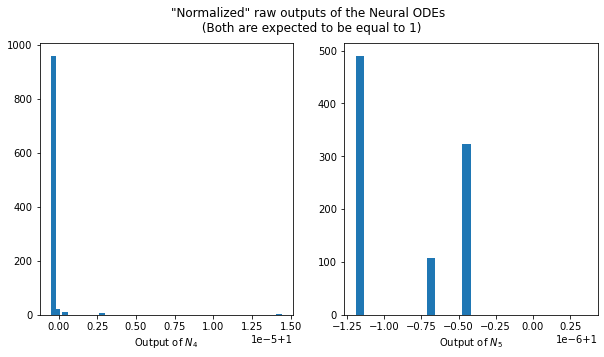

In [5]:
# Performance on training data
raw_pr1 = []
raw_pr2 = []
for [tau1, tau2, tau3] in taui:
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I4 = I4/inp_std4
    N4 = NODE(I4, NODE4_params) #I1^2
    # N4 = N4*out_std4
    raw_pr1.append(N4)
    
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3
    I5 = I5/inp_std5
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2
    # N5 = N5*out_std5
    raw_pr2.append(N5)
raw_pr1 = onp.array(raw_pr1)
raw_pr2 = onp.array(raw_pr2)

fig, ax = plt.subplots(1,2,figsize=[10,5])
ax[0].hist(raw_pr1, bins=50)
ax[1].hist(raw_pr2, bins=50)
ax[0].set(xlabel='Output of $N_4$')
ax[1].set(xlabel='Output of $N_5$')
fig.suptitle('\"Normalized\" raw outputs of the Neural ODEs \n (Both are expected to be equal to 1)')
pass

### 2. Train a $\Phi$ that has 2 Neural ODEs against Govindjee $\Phi$

In [6]:
def dPhi_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]

dphidtaui = onp.zeros_like(taui)
for i in range(taui.shape[0]):
    dphidtaui[i] = dPhi_gov(taui[i], etad=eta_D, etav=eta_V)

NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
params = [NODE4_params, NODE5_params]

def dPhi(params, tau1, tau2, tau3):
    NODE4_params, NODE5_params = params

    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N4 = N4*out_std4
    N5 = N5*out_std5

    Phi1 = 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 = 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 = 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return Phi1, Phi2, Phi3
dPhi_vmap = vmap(dPhi, in_axes=(None, 0, 0, 0), out_axes = (0, 0, 0))

def loss(params, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap(params, tau1, tau2, tau3)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)
params, train_loss = train(loss, taui, dphidtaui, opt_state, key, nIter=200000)

it 0, train loss = 3.917567e+00
it 10000, train loss = 1.367719e-07
it 20000, train loss = 9.736323e-16
it 30000, train loss = 5.429439e-14
it 40000, train loss = 1.287022e-11
it 50000, train loss = 1.076775e-13
it 60000, train loss = 3.470853e-13
it 70000, train loss = 6.461025e-14
it 80000, train loss = 8.153187e-14
it 90000, train loss = 1.700151e-10
it 100000, train loss = 3.038635e-12
it 110000, train loss = 1.168804e-11
it 120000, train loss = 2.010694e-13
it 130000, train loss = 9.230092e-14
it 140000, train loss = 2.540025e-15
it 150000, train loss = 1.406853e-12
it 160000, train loss = 1.899730e-13
it 170000, train loss = 5.935148e-10
it 180000, train loss = 1.928687e-15
it 190000, train loss = 1.389710e-12
it 200000, train loss = 2.335616e-10


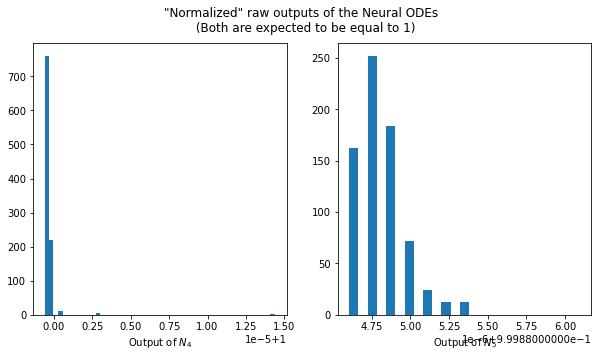

In [7]:
# Performance on training data
NODE4_params, NODE5_params = params

raw_pr1 = []
raw_pr2 = []
for [tau1, tau2, tau3] in taui:
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I4 = I4/inp_std4
    N4 = NODE(I4, NODE4_params) #I1^2
    # N4 = N4*out_std4
    raw_pr1.append(N4)
    
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3
    I5 = I5/inp_std5
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2
    # N5 = N5*out_std5
    raw_pr2.append(N5)
raw_pr1 = onp.array(raw_pr1)
raw_pr2 = onp.array(raw_pr2)

fig, ax = plt.subplots(1,2,figsize=[10,5])
ax[0].hist(raw_pr1, bins=50)
ax[1].hist(raw_pr2, bins=50)
ax[0].set(xlabel='Output of $N_4$')
ax[1].set(xlabel='Output of $N_5$')
fig.suptitle('\"Normalized\" raw outputs of the Neural ODEs \n (Both are expected to be equal to 1)')
pass

### 3. Train a $\Phi$ that has 5 Neural ODEs against the Govindjee $\Phi$

In [13]:
def dPhi_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]

dphidtaui = onp.zeros_like(taui)
for i in range(taui.shape[0]):
    dphidtaui[i] = dPhi_gov(taui[i], etad=eta_D, etav=eta_V)
    
NODE1_params = init_params_nobias(layers, key)
NODE2_params = init_params_nobias(layers, key)
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
params = [NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params]

def dPhi(params, tau1, tau2, tau3):
    NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = params

    I1 = tau1
    I2 = tau1 + tau2
    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    I1 = I1/inp_std1
    I2 = I2/inp_std2
    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N1 = NODE_nobias(I1, NODE1_params)
    N2 = NODE_nobias(I2, NODE2_params)
    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = np.max(np.array([N1, 0]))
    N2 = np.max(np.array([N2, 0]))

    N1 = N1*out_std1
    N2 = N2*out_std2
    N3 = N3*out_std3
    N4 = N4*out_std4
    N5 = N5*out_std5

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return Phi1, Phi2, Phi3
dPhi_vmap = vmap(dPhi, in_axes=(None, 0, 0, 0), out_axes = (0, 0, 0))

def loss(params, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap(params, tau1, tau2, tau3)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)
params, train_loss = train(loss, taui, dphidtaui, opt_state, key, nIter=200000)

with open('saved/phi_params.npy', 'wb') as f:
    pickle.dump(params, f)
    
with open('saved/phi_norm_w.npy', 'wb') as f:
    pickle.dump([inp_stds, out_stds], f)

it 0, train loss = 7.075950e+02
it 10000, train loss = 7.657487e-01
it 20000, train loss = 1.737417e-01
it 30000, train loss = 7.010344e-02
it 40000, train loss = 2.565880e-02
it 50000, train loss = 6.393687e-03
it 60000, train loss = 1.316486e-03
it 70000, train loss = 2.615670e-04
it 80000, train loss = 5.174732e-05
it 90000, train loss = 1.027371e-05
it 100000, train loss = 2.015816e-06
it 110000, train loss = 3.990641e-07
it 120000, train loss = 8.146685e-08
it 130000, train loss = 1.868943e-08
it 140000, train loss = 5.801960e-09
it 150000, train loss = 2.570934e-09
it 160000, train loss = 1.505457e-09
it 170000, train loss = 1.265804e-09
it 180000, train loss = 7.729498e-10
it 190000, train loss = 6.395952e-10
it 200000, train loss = 5.582973e-10


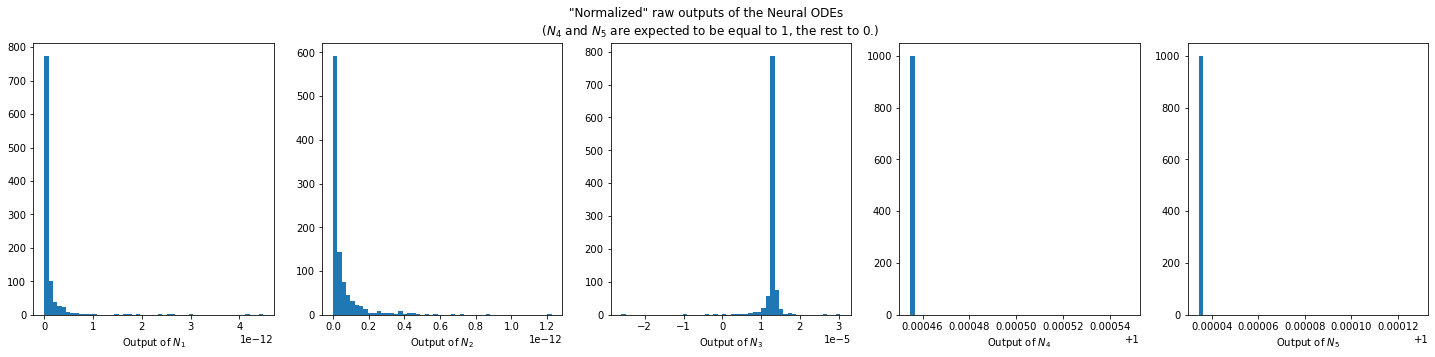

In [14]:
# Performance on training data
NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = params

raw_pr1 = []
raw_pr2 = []
raw_pr3 = []
raw_pr4 = []
raw_pr5 = []
for [tau1, tau2, tau3] in taui:
    I1 = tau1
    I2 = tau1 + tau2
    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3
    
    I1 = I1/inp_std1
    I2 = I2/inp_std2
    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N1 = NODE_nobias(I1, NODE1_params)
    N2 = NODE_nobias(I2, NODE2_params)
    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = np.max(np.array([N1, 0]))
    N2 = np.max(np.array([N2, 0]))
    
    raw_pr1.append(N1)
    raw_pr2.append(N2)
    raw_pr3.append(N3)
    raw_pr4.append(N4)
    raw_pr5.append(N5)
raw_pr1 = onp.array(raw_pr1)
raw_pr2 = onp.array(raw_pr2)
raw_pr3 = onp.array(raw_pr3)
raw_pr4 = onp.array(raw_pr4)
raw_pr5 = onp.array(raw_pr5)

fig, ax = plt.subplots(1,5,figsize=[25,5])
ax[0].hist(raw_pr1, bins=50)
ax[1].hist(raw_pr2, bins=50)
ax[2].hist(raw_pr3, bins=50)
ax[3].hist(raw_pr4, bins=50)
ax[4].hist(raw_pr5, bins=50)
ax[0].set(xlabel='Output of $N_1$')
ax[1].set(xlabel='Output of $N_2$')
ax[2].set(xlabel='Output of $N_3$')
ax[3].set(xlabel='Output of $N_4$')
ax[4].set(xlabel='Output of $N_5$')
fig.suptitle('\"Normalized\" raw outputs of the Neural ODEs \n ($N_4$ and $N_5$ are expected to be equal to 1, the rest to 0.)')
pass

Text(0.5, 0.98, 'New testing data within the same range as training data')

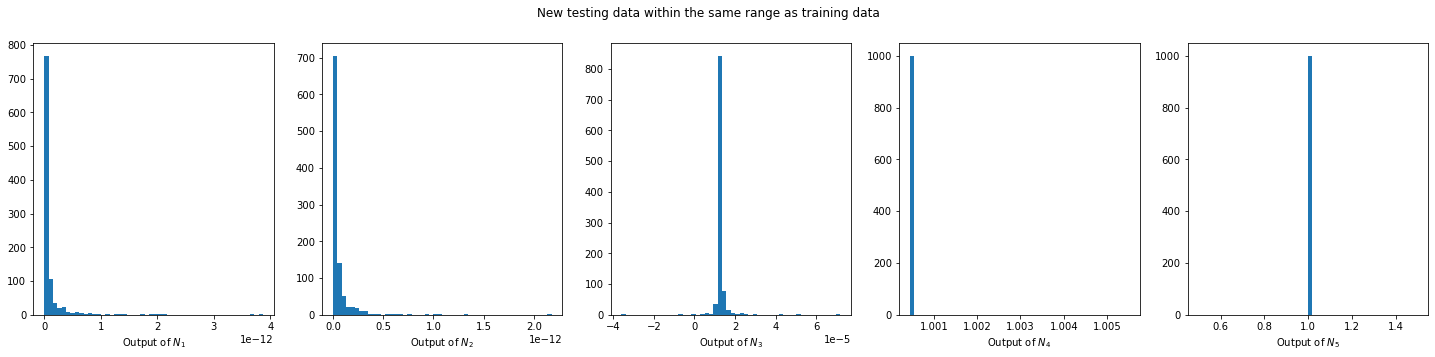

In [15]:
n = 1000
taui = onp.random.normal(size=[n,3])*200
taui = -onp.sort(-taui) #Sort taui in descending order

raw_pr1 = []
raw_pr2 = []
raw_pr3 = []
raw_pr4 = []
raw_pr5 = []
for [tau1, tau2, tau3] in taui:
    I1 = tau1
    I2 = tau1 + tau2
    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3
    
    I1 = I1/inp_std1
    I2 = I2/inp_std2
    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N1 = NODE_nobias(I1, NODE1_params)
    N2 = NODE_nobias(I2, NODE2_params)
    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = np.max(np.array([N1, 0]))
    N2 = np.max(np.array([N2, 0]))
    
    raw_pr1.append(N1)
    raw_pr2.append(N2)
    raw_pr3.append(N3)
    raw_pr4.append(N4)
    raw_pr5.append(N5)
raw_pr1 = onp.array(raw_pr1)
raw_pr2 = onp.array(raw_pr2)
raw_pr3 = onp.array(raw_pr3)
raw_pr4 = onp.array(raw_pr4)
raw_pr5 = onp.array(raw_pr5)

fig, ax = plt.subplots(1,5,figsize=[25,5])
ax[0].hist(raw_pr1, bins=50)
ax[1].hist(raw_pr2, bins=50)
ax[2].hist(raw_pr3, bins=50)
ax[3].hist(raw_pr4, bins=50)
ax[4].hist(raw_pr5, bins=50)
ax[0].set(xlabel='Output of $N_1$')
ax[1].set(xlabel='Output of $N_2$')
ax[2].set(xlabel='Output of $N_3$')
ax[3].set(xlabel='Output of $N_4$')
ax[4].set(xlabel='Output of $N_5$')
fig.suptitle('New testing data within the same range as training data')


Text(0.5, 0.98, 'Outside the training range ($\\tau_{max}=400$ instead of $200)$')

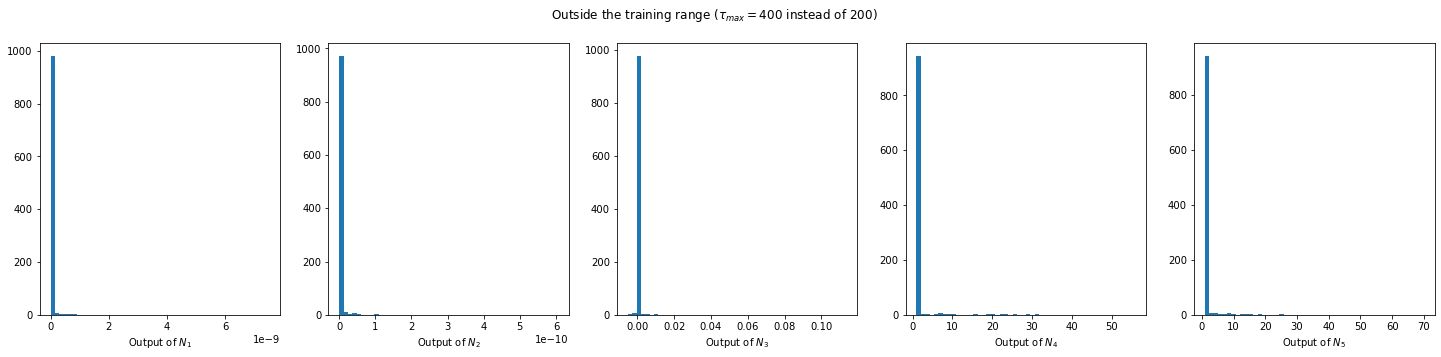

In [16]:
n = 1000
taui = onp.random.normal(size=[n,3])*400
taui = -onp.sort(-taui) #Sort taui in descending order

raw_pr1 = []
raw_pr2 = []
raw_pr3 = []
raw_pr4 = []
raw_pr5 = []
for [tau1, tau2, tau3] in taui:
    I1 = tau1
    I2 = tau1 + tau2
    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3
    
    I1 = I1/inp_std1
    I2 = I2/inp_std2
    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N1 = NODE_nobias(I1, NODE1_params)
    N2 = NODE_nobias(I2, NODE2_params)
    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = np.max(np.array([N1, 0]))
    N2 = np.max(np.array([N2, 0]))
    
    raw_pr1.append(N1)
    raw_pr2.append(N2)
    raw_pr3.append(N3)
    raw_pr4.append(N4)
    raw_pr5.append(N5)
raw_pr1 = onp.array(raw_pr1)
raw_pr2 = onp.array(raw_pr2)
raw_pr3 = onp.array(raw_pr3)
raw_pr4 = onp.array(raw_pr4)
raw_pr5 = onp.array(raw_pr5)

fig, ax = plt.subplots(1,5,figsize=[25,5])
ax[0].hist(raw_pr1, bins=50)
ax[1].hist(raw_pr2, bins=50)
ax[2].hist(raw_pr3, bins=50)
ax[3].hist(raw_pr4, bins=50)
ax[4].hist(raw_pr5, bins=50)
ax[0].set(xlabel='Output of $N_1$')
ax[1].set(xlabel='Output of $N_2$')
ax[2].set(xlabel='Output of $N_3$')
ax[3].set(xlabel='Output of $N_4$')
ax[4].set(xlabel='Output of $N_5$')
fig.suptitle(r'Outside the training range ($\tau_{max}=400$ instead of $200)$')